## This notebook consists of the evaluation of generated masks via metrics such as IOU

In [79]:
import os
import numpy as np
import pandas as pd
import glob
import torch
import re
import matplotlib.pyplot as plt
import nibabel as nib
from PIL import Image
import torchvision.transforms as transforms

In [80]:
os.getcwd()

'/home/ubuntu/DIFF_model/guided_diffusion'

In [129]:
#path to test img
predict_path = '../../data/samples'
predict_dirs = sorted(glob.glob(os.path.join(predict_path, '*.jpg')))

gt_path = '../../data/dlbs/Masks_dlbs'
gt_dirs = sorted(glob.glob(os.path.join(gt_path, '*.gz')))

In [137]:
def get_pairs(predict_dirs,gt_dirs):
    gt_pd_pair = []
    for i in predict_dirs:
        img_id = re.findall('/([^/_]+)_', i)

        img = Image.open(i)
        img = img.convert('L')
        transform = transforms.Compose([transforms.PILToTensor()])
        tensor = transform(img)
        
        pr_mask = np.array(tensor)/255
        pr_mask[pr_mask <= 0.5] = 0.0
        pr_mask[pr_mask > 0.5] = 1.0

        for j in gt_dirs:
            if img_id[0]+'_pve_0' in j:
                mask0 = nib.load(j).get_fdata()
                mask0 = mask0[:,13:205,:]
                mask0 = np.append(mask0, np.zeros((10, 192, 182)), axis=0)
                mask0 = np.append(mask0, np.zeros((192, 192, 10)), axis=2)

                mask0[mask0 <= 0.5] = 0.0
                mask0[mask0 > 0.5] = 1.0

                mask = torch.from_numpy(mask0[:,:,90]).type(torch.FloatTensor)
                gt_mask = torch.reshape(mask,(1,192,192))
                gt_mask = np.array(gt_mask)
                #print(pr_mask.shape)
                #print(gt_mask.shape)
                assert(pr_mask.shape == gt_mask.shape)
                #print(img_id[0])
                #print(j)
                gt_pd_pair.append((pr_mask,gt_mask,img_id))
    return gt_pd_pair


In [138]:
pairs = get_pairs(predict_dirs,gt_dirs)

['0028583']


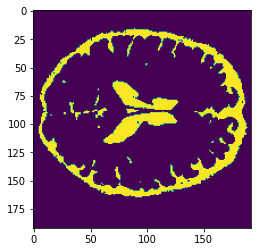

In [139]:
index = 2
print(pairs[index][2])
plt.imshow(pairs[index][0].squeeze())

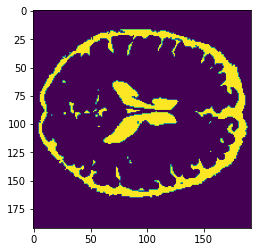

In [140]:
plt.imshow(pairs[index][1].squeeze())

In [141]:
def get_iou(a,b):
    intersect = np.logical_and(a,b).sum()
    union = a.sum() + b.sum() - intersect
    return intersect/union

In [142]:
get_iou(pairs[index][0],pairs[index][1])

0.8994082840236687

In [143]:
def get_dice(a,b):
    overlap = np.logical_and(a,b).sum()
    
    return 2*overlap/(a.sum()+b.sum())
    

In [144]:
iou = 0
dice = 0
for i in pairs:
    iou += get_iou(i[0],i[1])
    dice += get_dice(i[0],i[1])
iou = iou/len(pairs)
dice = dice/len(pairs)

In [145]:
print("Average IOU is: ", iou)
print("Average DICE is: ", dice)

Average IOU is:  0.9252995764507488
Average DICE is:  0.9611055270146485
